In [3]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


In [41]:
# !pip install gplearn
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import copy
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn as sk
import matplotlib as mp
import random
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pandas import Series
from numpy.random import randn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV,StratifiedKFold,cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [279]:
raw = pd.read_csv(r"/Users/zhanganqi/Desktop/867/final/creditdata_features2.csv", 
                  ).iloc[:, 1:]  #remove index col
#remove missing birth date rows and age >=100 rows
df = raw[raw['Age'] < 100].copy().reset_index(drop=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

df.shape

(43806, 37)

In [280]:
df['Credit.Score.Code'] = df['Credit.Score.Code'].astype(int)

In [281]:
## Creating a Function to Distribute the Behavior Score
def func(x):
    if(x >=300 and x<580):
        return 1
    elif(x>=580 and x<670):
        return 2
    elif(x>=670 and x<740):
        return 3
    elif(x>=740 and x<799):
        return 4
    elif(x>=800 and x<=850):
        return 5
    else: 
        return 0
    
df['Behavior.Score.Number'] = df['Behavior.Score.Number'].apply(func)

In [282]:
#df[date] = df[date].fillna('0000-00-00')
#df['Account.System.Entry.Date'] = pd.to_datetime(df['Account.System.Entry.Date']).dt.strftime('%Y-%m-%d')

# 'Account.System.Entry.Date', 'Annual.Charge.Last.Post.Date',
#                               'Cash.Last.Date','Account.Payment.Last.Date',
#                               'Account.Delinquent.Last.Date', 'Last.Merchandise.Purchase.Date',
#                               'Credit.Line.Review.Last.Date'

In [283]:
df['Behavior.Score.Number'] = df['Behavior.Score.Number'].astype('category')

In [284]:
#Identify numerical and categorical variabls
numerical = [f for f in df.columns if df.dtypes[f] != 'object']

categorical = [f for f in df.select_dtypes(exclude=['int64','float64']).columns]
categorical

['Behavior.Score.Number']

In [285]:
# replacing/imputing missing data

# Approach:
# Categorical features: adding new category 'missing_value' 
# Numerical features: replacing with a median (or mean, or most frequent value, etc.) 
#An alternative approach is to imputate, see here: https://scikit-learn.org/stable/modules/impute.html 
# + we add surrogate columns indicating that the value is imputed

# creating surrogates
for col in df:
    if df[col].isna().sum() != 0: 
        df[col + '_surrogate'] = df[col].isna().astype(int)

# fixing categoricals
imputer = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(df.select_dtypes(exclude=['int64','float64']))
           
# fixing numericals 
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
imputer.fit(df.select_dtypes(include=['int64','float64']))
df[df.select_dtypes(include=['int64','float64']).columns] = imputer.transform(df.select_dtypes(include=['int64','float64']))



In [286]:
#Convert categorical variables to dummy variables 
def PerformOneHotEncoding(df,columnsToEncode):
    return pd.get_dummies(df,columns = columnsToEncode)

df = PerformOneHotEncoding(df,categorical)


In [287]:
# splitting train, test and pred data
train_df = df[:39425].copy().drop(['Current.Statement.Status_Final'], axis=1)
test_df = df[:39425].copy().loc[:, 'Current.Statement.Status_Final']

x_pred = df[39425:].copy().iloc[:, :-1]
# y_actual = df[42806:].copy().loc[:, 'Current.Statement.Status_Final']

# Random approach uses train-test split function.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_df, test_df, 
                                                    test_size=0.1, random_state=42)



In [288]:
# define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format:  tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return ((tn+tp)/(tn+tp+fn+fp))

In [289]:
# Select the threshold value -- 
#we will use Т=0.18 as it is the average probability of default in our data (7944 "1"s out of 43806 datapoints) 
class_threshold = 0.18

# Model №1: Logistic regression

In [290]:
# define the model and call it classifier_LR
classifier_LR = LogisticRegression(solver='liblinear')

# train classifier_LR on the training data
classifier_LR.fit(x_train, y_train)

print('Intercept: ' + str(classifier_LR.intercept_))
print('Coefficients (10 largest and 10 smallest) ')
summary = pd.DataFrame([x_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Variable','Coefficient']
top10positive = summary.head(10) # 10 largest (by value)
top10negative = summary.tail(10) # 10 smallest (by value)
top10list=pd.DataFrame()
top10list= top10list.append(pd.DataFrame(data = top10positive))
top10list= top10list.append(pd.DataFrame(data = top10negative))
top10list

Intercept: [-8.50600984e-05]
Coefficients (10 largest and 10 smallest) 


,Variable,Coefficient
38,Behavior.Score.Number_0.0,0.276211
26,Merchandise.Annual.Interest.Rate,0.130251
40,Behavior.Score.Number_2.0,0.0908831
29,Account.System.Entry.Date.Diff,0.0254983
39,Behavior.Score.Number_1.0,0.0149084
4,Delinquent.05.Cycle.Amount,0.00572944
2,Delinquent.03.Cycle.Amount,0.00411443
17,Previous.Statement.Late.Charge.Unpaid.Amount,0.00154842
6,Delinquent.07.Cycle.Amount,0.00136567
12,Last.Statement.Charge.Late.Amount,0.00130664


In [291]:
# Use the trained model to predict testing data

y_pred_prob = classifier_LR.predict_proba(x_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # applying the threshold rule to classify

# print(y_pred_prob[0:5]) # first 5 probabilities 
# print(y_pred[0:5]) # resultant predicted classification 
# print(y_test[0:5]) # actual outcomes


Metrics of the logistic regression model: 

Confusion matrix: 
[[2680  220]
 [ 520  523]]
                                   Accuracy: 0.8123256403753487
                   SENSITIVITY (aka RECALL): 0.8375
                 SPECIFICITY (aka FALL-OUT): 0.7039030955585465
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9241379310344827
                 NEGATIVE PREDICTIVE VALUE): 0.50143815915628


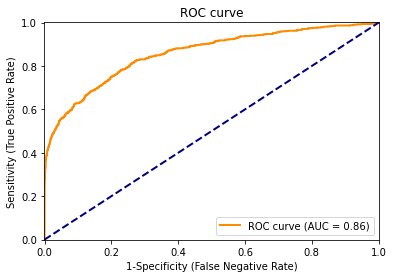

 AUC: 0.8572926480484522


In [292]:
# Lets look at the model metrics 
print('Metrics of the logistic regression model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


In [293]:
# Apply variable selection with Stepwise Recursive Feature Selection 

from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier_LR, n_features_to_select=30, step=1) 
rfe.fit(x_train, y_train)
ranking = rfe.ranking_.reshape(len(x_train.columns))

# which 20 variables are in the model?
pd.DataFrame([x_test.columns,ranking]).transpose().sort_values(1).head(30)


,0,1
0,Delinquent.01.Cycle.Amount,1
22,Before.Previous.Statement.Past.Due.One.Amount,1
23,Cash.Annual.Interest.Rate,1
26,Merchandise.Annual.Interest.Rate,1
28,Credit.Score.Code,1
29,Account.System.Entry.Date.Diff,1
32,Last.Merchandise.Purchase.Date.Diff,1
42,Behavior.Score.Number_4.0,1
33,Credit.Line.Review.Last.Date.Diff,1
36,Credit.Line.Review.Last.Date_surrogate,1


Metrics of the logistic regression model after variable selection: 

Confusion matrix: 
[[2701   71]
 [ 499  672]]
                                   Accuracy: 0.8554400202891199
                   SENSITIVITY (aka RECALL): 0.8440625
                 SPECIFICITY (aka FALL-OUT): 0.9044414535666218
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9743867243867244
                 NEGATIVE PREDICTIVE VALUE): 0.5738684884713919


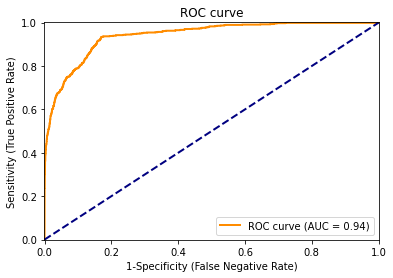

 AUC: 0.9400214502018843


In [294]:
# Train the model and call it classifier_LR_RFE 
classifier_LR_RFE = rfe.fit(x_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = classifier_LR_RFE.predict_proba(x_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification


# Lets look at the model metrics after variable selection 
print('Metrics of the logistic regression model after variable selection: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


# Method №2: Classification and Regression Tree, CART (aka "decision tree")

In [295]:
# Define a CART model and call it classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Train the model classifier_DT on the training data
classifier_DT.fit(x_train, y_train)

#  Use the trained model to predict testing data
y_pred_prob = classifier_DT.predict_proba(x_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# print(y_pred_prob[0:5]) # first 5 probabilities 
# print(y_pred[0:5]) # resultant predicted classification 
# print(y_test[0:5]) # actual outcomes



CART tree with 5 leafs


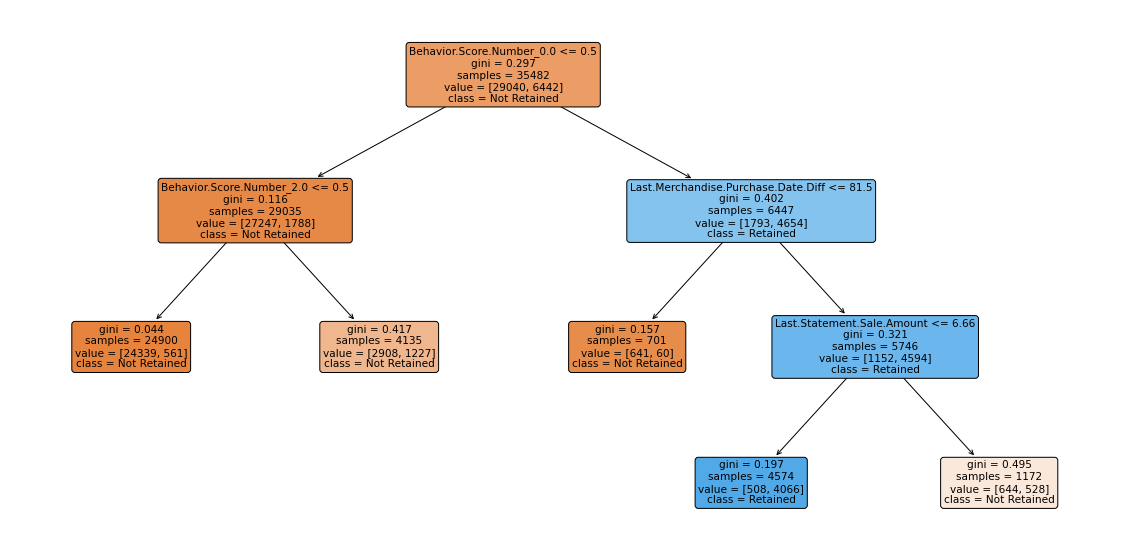

In [296]:
# Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(classifier_DT.fit(x_train, y_train), feature_names = x_train.columns, filled = True, 
               class_names = ['Not Retained', 'Retained'], rounded = True)
print('CART tree with 5 leafs')


Metrics of the CART model: 

Confusion matrix: 
[[2748   74]
 [ 452  669]]
                                   Accuracy: 0.8665990362668019
                   SENSITIVITY (aka RECALL): 0.85875
                 SPECIFICITY (aka FALL-OUT): 0.9004037685060565
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9737774627923459
                 NEGATIVE PREDICTIVE VALUE): 0.5967885816235504


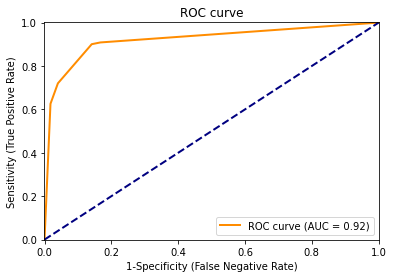

 AUC: 0.9207021786675639


In [297]:
# Lets look at the model metrics

print('Metrics of the CART model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [298]:
DecisionTreeClassifier() # display what those hyper-parameters are and their default values

DecisionTreeClassifier()

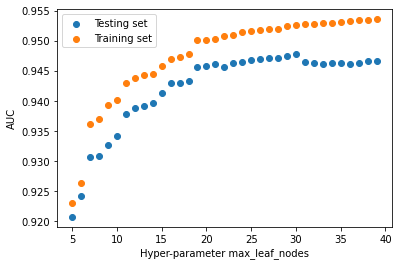

In [299]:
# Tuning hyper-parameter max_leaf_nodes

n_max_leaf_nodes = range(5,40) # Lets train the models with 5, 6, 7, ... 40 leafs

# for each model calculate AUC for testing 
array = []
for n in n_max_leaf_nodes:
    
    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(x_train, y_train)
    
    y_pred_prob = classifier_DT.predict_proba(x_test)[:,1]   
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_test, y_pred_prob)])

# plot the testing set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# now for each model calculate AUC on training 
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(x_train, y_train)
    
    y_pred_prob = classifier_DT.predict_proba(x_train)[:,1] 
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_train, y_pred_prob)])

# plot the training set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# label the axes on the plot
plt.xlabel('Hyper-parameter max_leaf_nodes')
plt.ylabel('AUC')

# add the legend
plt.legend(['Testing set','Training set'])


In [300]:
# lets train the model with 8 leafs
classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = 8)
classifier_DT = classifier_DT.fit(x_train, y_train)

# obtain its predictions
y_pred_prob = classifier_DT.predict_proba(x_test)[:,1]   
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

# calclate and print the AUC
print(" after-tunning CART AUC : " + str(roc_auc_score(y_test, y_pred_prob)))

 after-tunning CART AUC : 0.9308123738223417


# Method №3: Random Forest

In [301]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=77300)

# Train the model classifier_RF on the training data
classifier_RF.fit(x_train, y_train)


RandomForestClassifier(random_state=77300)

Metrics of the Random Forest model: 

Confusion matrix: 
[[2868   48]
 [ 332  695]]
                                   Accuracy: 0.9036266801927466
                   SENSITIVITY (aka RECALL): 0.89625
                 SPECIFICITY (aka FALL-OUT): 0.9353970390309556
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9835390946502057
                 NEGATIVE PREDICTIVE VALUE): 0.676728334956183


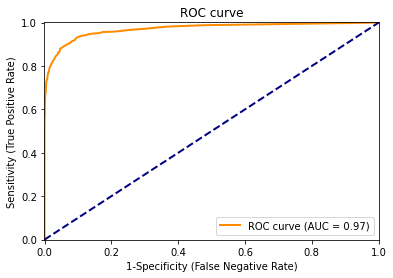

 AUC: 0.9704874663526245


In [302]:
# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(x_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Random Forest model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


Optimized hyper-parameters:{'n_estimators': 200}
Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": 

Confusion matrix: 
[[2862   49]
 [ 338  694]]
                                   Accuracy: 0.9018513821962972
                   SENSITIVITY (aka RECALL): 0.894375
                 SPECIFICITY (aka FALL-OUT): 0.9340511440107672
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.983167296461697
                 NEGATIVE PREDICTIVE VALUE): 0.6724806201550387


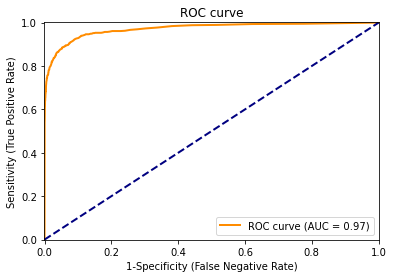

 AUC: 0.9711480063930014


In [303]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

n_trees = [100, 200, 300, 400, 500, 600] 
Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_RF, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# apply function grid_search to the training data, call the resultand best model grid_search_RF
grid_search_RF = grid_search.fit(x_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_RF.predict_proba(x_test)[:,1] # probabilities  
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))
    
# Lets look at the model metrics

print('Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='Decrease in Gini (recal, Gini = 2*AUC-1)'>

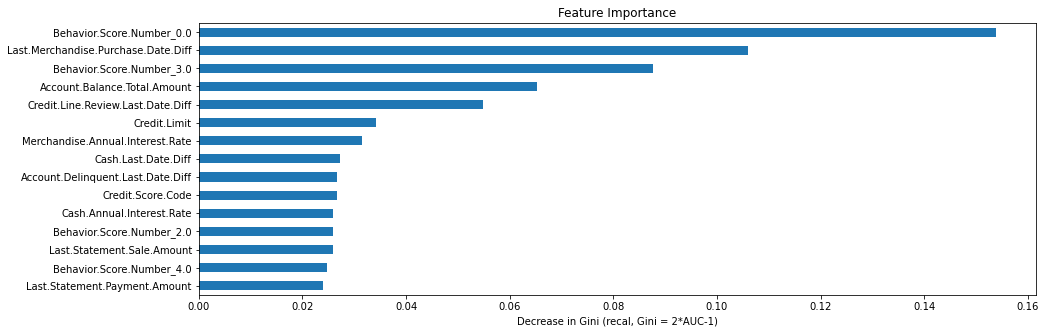

In [304]:
# calculate feature importances
importances = grid_search_RF.best_estimator_.feature_importances_ 

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=x_train.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

# Method №4: Support Vector Machines

In [305]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_estimators = []
svm_estimators.append(('standardize', StandardScaler())) # scale the data
svm_estimators.append(('svm', svm.SVC(probability=True)))
     
# Define the support vectors machine model and call it classifier_SVM
Classifier_SVM = Pipeline(svm_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_SVM.fit(x_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('svm', SVC(probability=True))])

Metrics of the Support Vector Machines model: 

Confusion matrix: 
[[3051  187]
 [ 149  556]]
                                   Accuracy: 0.9147856961704286
                   SENSITIVITY (aka RECALL): 0.9534375
                 SPECIFICITY (aka FALL-OUT): 0.7483176312247645
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.94224830142063
                 NEGATIVE PREDICTIVE VALUE): 0.7886524822695036


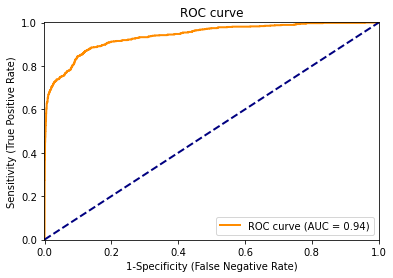

 AUC: 0.9395548031628532


In [306]:
# use the fitted model to predict the testing data 
y_pred_prob = Classifier_SVM.predict_proba(x_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Support Vector Machines model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Prediction

In [307]:
# Since the RF model with optimized hyper-parameters obtained the higest AUC, lets take that; recall it is called grid_search_RF
x_pred = x_pred.reset_index().rename(columns={'index': 'ID'})
x_pred2 = x_pred.drop(columns=['ID'])

y_pred_prob = grid_search_RF.predict_proba(x_pred2)[:,1] # probabilities
y_pred_default = np.where(y_pred_prob > class_threshold, 1, 0) # classification default  1： default
y_pred_issued = np.where(y_pred_prob > class_threshold, 0, 1) # classification issued

In [309]:
len(x_pred)

4381

In [318]:
# Lets add the ID column to know "who is who"
Prediction = pd.DataFrame(data={"ID":x_pred["ID"], "Predicted Probability":y_pred_issued}) 

#Export the predictions into a CSV file
Prediction.to_excel(r"/Users/zhanganqi/Desktop/867/final/prediction.xlsx")
final.to_excel(r'/Users/zhanganqi/Desktop/867/final/last_4000_clients_with_predicted_result.xlsx')